# Regression Modeling for Outcome Prediction

 This notebook demonstrates the full pipeline for predicting the continuous target `outcome` 
 from a diamond dataset. We will:

 1. **Explore the data (EDA):** Look at the data structure, summary statistics, correlations,
    and distributions. We also visualize the correlation matrix.

 2. **Data Preprocessing & Feature Engineering:**  
    - Remove rows with invalid dimensions (i.e. where `x`, `y`, or `z` equals zero).  
    - Drop the `price` column due to high multicollinearity with physical features.  
    - Explore redundancy among `x`, `y`, `z` and create a new feature `volume = x * y * z`.  
    - Compare correlations between `x, y, z` versus `volume` with the target.
    - One-hot encode categorical variables (`cut`, `color`, `clarity`).

 3. **Modeling:**  
    We build three models:
    - Linear Regression
    - Random Forest Regressor
    - XGBoost Regressor

    Each model is evaluated using 5‑fold cross-validation (R² as the metric) with a fixed seed.
    Finally, we select the best performing model and generate predictions on the test set.

 **Note:** Replace `"CW1_submission_KNUMBER.csv"` with your actual ID filename.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#1. Data Loading and Initial Exploration (EDA)

#We load the training and test data. The training data has 31 columns including the target
# outcome, while the test data has 30 columns (without "outcome").

# Load data
train = pd.read_csv("/home/abdullah/year2_proj/ML_CW1/CW1_train.csv")
test = pd.read_csv("/home/abdullah/year2_proj/ML_CW1/CW1_test.csv")

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("\nTraining data columns:\n", train.columns.tolist())

# Display first few rows
train.head()

# Summary statistics
print(train.describe())

Training data shape: (10000, 31)
Test data shape: (1000, 30)

Training data columns:
 ['outcome', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']
            outcome         carat         depth         table         price  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -4.979081      0.798407     61.748060     57.467360   3910.841900   
std       12.722224      0.472046      1.429631      2.247036   3940.369616   
min      -44.879471      0.200000     50.800000     44.000000    326.000000   
25%      -13.989962      0.400000     61.000000     56.000000    965.000000   
50%       -5.442794      0.710000     61.900000     57.000000   2441.000000   
75%        3.918593      1.040000     62.500000     59.000000   5226.000000   
max       39.675966      4.000000     70.500000     73.000000  18791.0

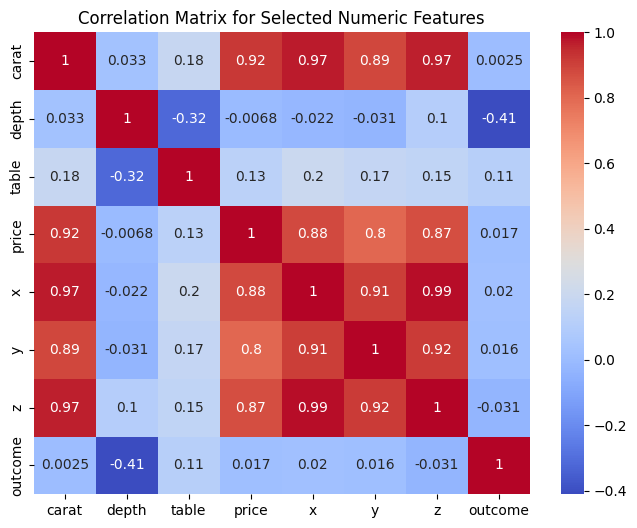

In [2]:
# Compute correlation matrix for numeric features
numeric_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
corr_matrix = train[numeric_features + ['outcome']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Selected Numeric Features")
plt.show()



# 2. Data Preprocessing and Feature Engineering

###    a) Removing Invalid Rows

    Remove rows where any of the dimensions (x, y, z) are zero since these are invalid (having dimensions with value 0 means mistake).


In [3]:
# Remove invalid rows
train = train[(train['x'] > 0) & (train['y'] > 0) & (train['z'] > 0)].copy()
print("Training data shape after removing invalid rows:", train.shape)



Training data shape after removing invalid rows: (9996, 31)



### b) Dropping Redundant Features

The `price` column is highly correlated with multiple other features (multicollinearity) and does not add unique information
for predicting `outcome` (can actually hinder the model). Therefore, we drop it from both train and test.

In [4]:
# Drop 'price'
if 'price' in train.columns:
    train.drop(columns=["price"], inplace=True)
if 'price' in test.columns:
    test.drop(columns=["price"], inplace=True)

train.head()

,outcome,carat,cut,color,clarity,depth,table,x,y,z,...,a6,a7,a8,a9,a10,b6,b7,b8,b9,b10
0,-26.701232,1.14,Ideal,G,VS1,62.3,56.0,6.73,6.70,4.18,...,0.168836,-0.273758,1.107832,1.247795,0.482344,0.489511,-0.321138,0.573382,0.446871,-1.990581
1,6.548093,0.38,Premium,H,VS2,60.5,59.0,4.69,4.66,2.83,...,-0.256549,0.315373,-0.030326,-0.114335,-1.059588,-1.761360,-1.343951,-1.002550,-0.225030,-0.446653
2,6.612562,0.50,Very Good,E,SI1,60.7,58.0,5.09,5.13,3.10,...,-1.193327,-0.657307,-0.591726,-0.446856,-0.765286,-0.816544,-1.397794,-0.477130,0.810509,1.725131
3,-5.073562,0.70,Premium,D,SI1,61.2,58.0,5.74,5.70,3.50,...,-1.740788,-1.778860,-0.825070,0.444932,1.173109,0.453606,-0.263440,0.246210,-0.850503,-0.412950
4,-14.436557,0.83,Ideal,G,SI2,62.4,54.0,6.01,6.08,3.77,...,-0.859322,1.409268,0.861992,1.109063,-1.436722,-1.461618,0.081787,0.258087,0.851146,2.204813


### c) Creating a 'Volume' Feature

 The features `x`, `y`, and `z` are strongly correlated and represent the dimensions of a diamond.
 We can compute a new feature `volume = x * y * z` to capture the overall size and then drop `x, y, z`.

 We compare the correlation of `volume` with the target `outcome` to that of the individual dimensions.

In [5]:
# Create 'volume' feature
train['volume'] = train['x'] * train['y'] * train['z']
test['volume'] = test['x'] * test['y'] * test['z']

# Compare correlations
print("Correlation of x with outcome:", train['x'].corr(train['outcome']))
print("Correlation of volume with outcome:", train['volume'].corr(train['outcome']))
print("Correlation of y with outcome:", train['y'].corr(train['outcome']))
print("Correlation of z with outcome:", train['z'].corr(train['outcome']))




Correlation of x with outcome: 0.02047738724704877
Correlation of volume with outcome: 0.004341450674216373
Correlation of y with outcome: 0.016036131446888976
Correlation of z with outcome: -0.029914226329548356


In [6]:
# For our pipeline, we'll keep volume and drop x, y, z
train.drop(columns=["x", "y", "z"], inplace=True)
test.drop(columns=["x", "y", "z"], inplace=True)

### d) One-Hot Encoding of Categorical Variables

the categorical features `cut`, `color`, and `clarity` are one-hot encoded. We drop the first
category for each to avoid multicollinearity (dummy variable trap).

In [7]:
cat_cols = ["cut", "color", "clarity"]
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Ensure test data has the same columns (except outcome)
target_col = "outcome"
feature_cols = [col for col in train.columns if col != target_col]
test = test.reindex(columns=feature_cols, fill_value=0)

### e) Standardising Numeric Features

We standardise continuous numeric features so that they are on a similar scale. This is useful for linear regression and can help tree-based models.


In [8]:
# Identify numeric columns (we assume one-hot encoded columns are non-numeric for scaling)
dummy_prefixes = ['cut_', 'color_', 'clarity_']
all_features = train.drop(columns=[target_col]).columns.tolist()
dummy_cols = [col for col in all_features if any(col.startswith(pref) for pref in dummy_prefixes)]
numeric_cols = [col for col in all_features if col not in dummy_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# Scaling mainly for the linear models we'll use
train.describe()

,outcome,carat,depth,table,a1,a2,a3,a4,a5,b1,...,a7,a8,a9,a10,b6,b7,b8,b9,b10,volume
count,9996.000000,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,...,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03,9.996000e+03
mean,-4.983359,-6.397444e-17,-3.599628e-15,-4.798083e-15,2.914391e-17,-2.843308e-18,8.387759e-17,2.125373e-16,-4.513752e-17,9.951579e-18,...,1.848150e-17,1.563820e-17,-1.794838e-17,-1.208406e-17,-2.061398e-17,-1.208406e-17,1.990316e-17,3.518594e-17,7.819098e-18,-9.169669e-17
std,12.721743,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-44.879471,-1.267740e+00,-7.660715e+00,-5.993093e+00,-1.726161e+00,-1.742249e+00,-1.741686e+00,-1.738925e+00,-1.731994e+00,-1.736740e+00,...,-3.689075e+00,-3.749091e+00,-3.506872e+00,-3.507816e+00,-3.744805e+00,-4.016746e+00,-4.265408e+00,-3.627531e+00,-3.833216e+00,-1.163352e+00
25%,-13.993363,-8.438990e-01,-5.235589e-01,-6.528241e-01,-8.674312e-01,-8.802747e-01,-8.664826e-01,-8.576011e-01,-8.701155e-01,-8.662181e-01,...,-6.866625e-01,-6.676527e-01,-6.581219e-01,-6.664968e-01,-6.817591e-01,-6.687072e-01,-6.685042e-01,-6.638511e-01,-6.682977e-01,-7.596575e-01
50%,-5.446691,-1.869461e-01,1.061902e-01,-2.078018e-01,-1.122474e-03,8.444564e-03,5.865157e-03,1.289137e-03,-1.963834e-03,7.037219e-03,...,1.028431e-02,1.628790e-02,-1.094947e-03,-4.434989e-03,9.068132e-03,2.605651e-02,5.589200e-03,-1.005350e-02,-7.401464e-03,-1.786284e-01
75%,3.911963,5.123909e-01,5.260229e-01,6.822430e-01,8.620594e-01,8.833571e-01,8.564596e-01,8.647919e-01,8.748729e-01,8.554450e-01,...,6.820355e-01,6.602045e-01,6.713810e-01,6.816701e-01,6.684464e-01,6.631627e-01,6.734428e-01,6.807960e-01,6.620744e-01,4.724885e-01
max,39.675966,6.785232e+00,6.123793e+00,6.912556e+00,1.709229e+00,1.691499e+00,1.717161e+00,1.729008e+00,1.727862e+00,1.737323e+00,...,3.601134e+00,4.219743e+00,3.688112e+00,4.133726e+00,4.031984e+00,3.846113e+00,4.046699e+00,3.785869e+00,3.461447e+00,4.381825e+01


# 3. Exploratory Data Analysis (Post-Processing)

check the final feature set and the correlation of these features with `outcome`.

In [9]:
print("Final feature columns (training):", train.drop(columns=[target_col]).columns.tolist())

# Correlation with outcome
corr_with_outcome = train.corr()[target_col].drop(target_col).sort_values(ascending=False)
print("\nCorrelation with outcome:\n", corr_with_outcome)

Final feature columns (training): ['carat', 'depth', 'table', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10', 'volume', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']

Correlation with outcome:
 b3               0.225374
b1               0.173464
a1               0.149210
a4               0.122474
table            0.114946
cut_Premium      0.063190
cut_Ideal        0.034839
color_E          0.022074
color_H          0.021023
clarity_VS1      0.018129
clarity_IF       0.015600
b5               0.012341
a7               0.012324
clarity_VVS2     0.010063
clarity_VVS1     0.009979
a2               0.008345
a8               0.008079
a6               0.007391
clarity_SI2      0.006262
a9               0.005865
volume           0.004341
a3 

# 4. Model Building and Evaluation

now evaluate three regression models:

1. **Linear Regression**  
2. **Random Forest Regressor**  
3. **XGBoost Regressor**

We use 5-fold cross-validation (${R^2}$ as the metric) for each model.

All models use a fixed random seed for reproducibility.

In [10]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

RANDOM_STATE = 42

# Separate features and target from training data
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

# Define 10-fold CV
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Function to evaluate model with CV and print results
def evaluate_model(model, model_name=""):
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    print(f"{model_name} | Mean R²: {scores.mean():.3f} | Std: {scores.std():.3f}")
    return scores.mean()

In [11]:
# Model 1: Linear Regression
lr = LinearRegression()
lr_r2 = evaluate_model(lr, "Linear Regression")

Linear Regression | Mean R²: 0.288 | Std: 0.018


In [20]:
# Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1) #-1 means using all processors
rf_r2 = evaluate_model(rf, "Random Forest")

Random Forest | Mean R²: 0.457 | Std: 0.025


In [13]:
# model 3 : Neural Network
nn = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', random_state=RANDOM_STATE, early_stopping=True,max_iter=1000)
nn_r2 = evaluate_model(nn, "Neural Network")

Neural Network | Mean R²: 0.372 | Std: 0.027


In [21]:
# Model 4: XGBoost Regressor
xgb = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=6, random_state=RANDOM_STATE,n_jobs=-1)
xgb_r2 = evaluate_model(xgb, "XGBoost")

XGBoost | Mean R²: 0.452 | Std: 0.021


In [15]:
# Summarise results
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "Neural Network"],
    "R² value": [lr_r2, rf_r2, xgb_r2, nn_r2]
})
print(results)

               Model  R² value
0  Linear Regression  0.288201
1      Random Forest  0.457338
2            XGBoost  0.452160
3     Neural Network  0.372335


# 5. Final Model Selection and Test Set Prediction
choose best model and retrain it on the full training data and generate predictions for test set

In [16]:
best_model = rf  # RandomForest Produce best R2 value

# Retrain on full training data
best_model.fit(X_train, y_train)

# Generate predictions on the test set
test_predictions = best_model.predict(test)

# Create submission DataFrame and save to CSV
submission = pd.DataFrame({'yhat': test_predictions})
submission_filename = "CW1_submission_K20009401.csv"  
submission.to_csv(submission_filename, index=False)
print("Submission file saved as:", submission_filename)

Submission file saved as: CW1_submission_K20009401.csv
